# next
* fix all tests
* simulate brain below with and without hebbian learning AND decrease random perturbation over time
* create a ground neuron that is always on (this is needed to create a NAND)
* directly create a NAND (maybe make a nand classmethod constructor)
* see if you can converge to a NAND given an initial topology that works
* do all synapses need to have the possibility of being both inhibitory and excitatory? what then?

In [16]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [50,50]

import brain; import importlib; importlib.reload(brain);

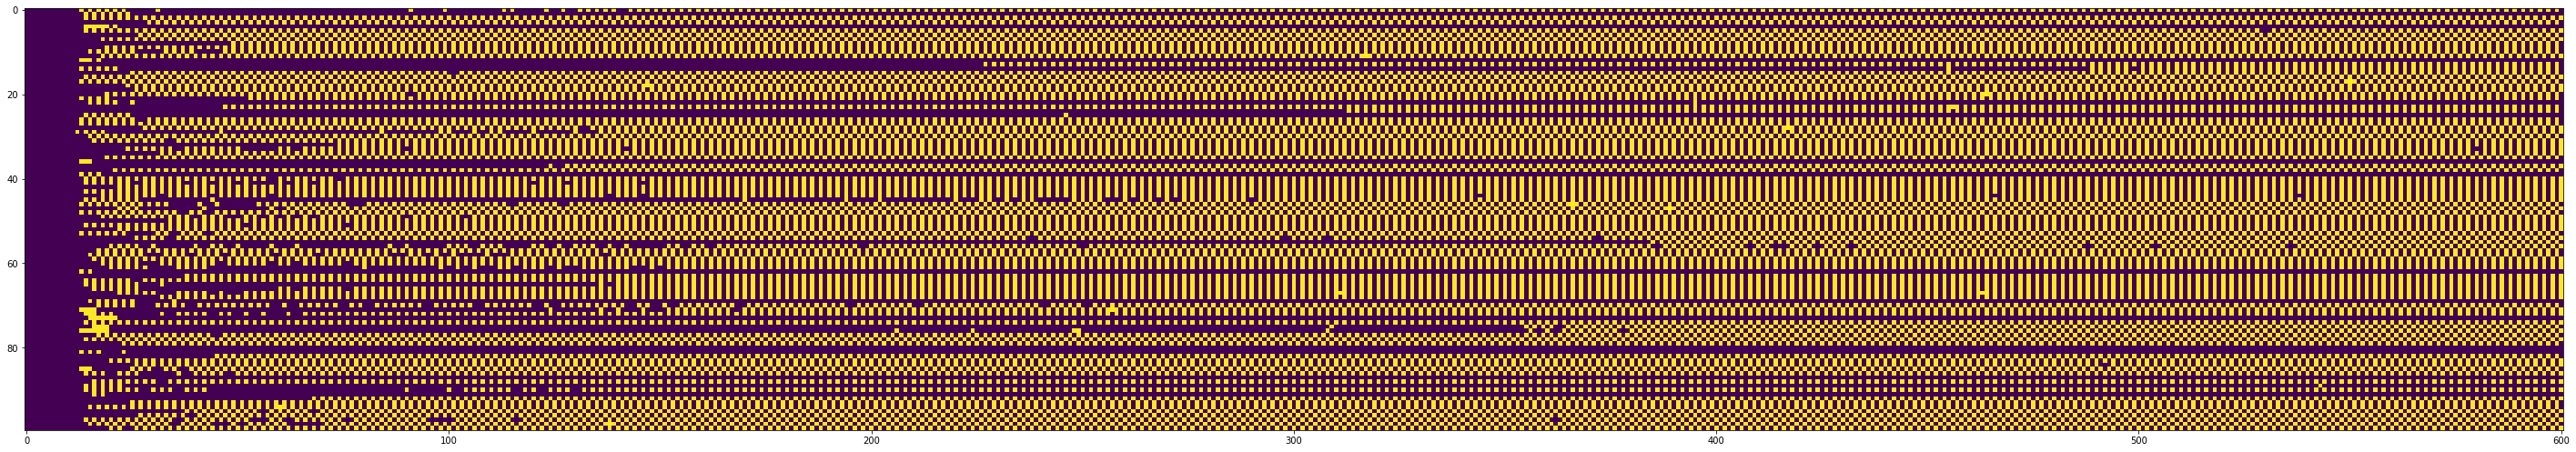

In [47]:
b = brain.Brain(
    num_neurons=100, 
    excitatory_synaptic_density=0.2,
    inhibitory_synaptic_density=0.4,
    neuronal_threshold=1,
    probability_of_random_excitation=0.001,
    initial_active_neuron_density=0.5,
)
b.simulate_brain(
    600,
    with_hebbian_learning=True,
)